# Table of Contents
[I.   Benchmark with Floating-point Operations Per Second (FLOPS) Calculator](#Test01)

[II.  Benchmark with MNIST dataset](#Test02)

[III. Benchmark with Zalando MNIST dataset](#Test02)

In [1]:
##
# Import required libraries:
#
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time

##
# Import functions:
#
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import mixed_precision
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from utils import process_mnist, models

In [2]:
##
# Recheck to see if GPU will be available:
#
device_name = tensorflow.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
##
# Set up the precision target:
#
policy = tensorflow.keras.mixed_precision.experimental.Policy('float32')
tensorflow.keras.mixed_precision.experimental.set_policy(policy)

# I. Benchmark with Floating-point Operations Per Second (FLOPS) Calculator <a name = 'Test01'></a>

In [4]:
##
# Compute the flops of this model
#
session = tensorflow.compat.v1.Session()
graph = tensorflow.compat.v1.get_default_graph()

with graph.as_default():
    with session.as_default():
        models.model_VGG19()
        run_meta = tensorflow.compat.v1.RunMetadata()
        opts = tensorflow.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tensorflow.compat.v1.profiler.profile(graph=graph,
                                                      run_meta=run_meta, cmd='op', options=opts)

tensorflow.compat.v1.reset_default_graph()

print(f"Number of flops: {round(flops.total_float_ops, 0)}")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Number of flops: 115530156


# II. Benchmark with MNIST dataset <a name = 'Test02'></a>

In [5]:
##
# Load the MNIST dataset:
#

data_location = int(input('Select the option to load data (0 = from the server; 1 = manually from the directory): '))

if data_location == 0:
    X, y = fetch_openml('mnist_784', version = 1, return_X_y = True, as_frame = False)
    
    ##
    # Convert the input data into RGB image type and resize the resolution to 32x32:
    #
    X = process_mnist.resize_mnist(X, 32, 28)
    X = np.stack((X,) * 3, axis = -1)
    
    ##
    # One-hot encoding the output labels:
    #
    y = to_categorical(y, num_classes = 10)
    
elif data_location == 1:
    X_train, y_train = process_mnist.load_mnist('data/mnist', kind = 'train')
    X_test, y_test = process_mnist.load_mnist('data/mnist', kind = 't10k')
    
    ##
    # Convert the input data into RGB image type and resize the resolution to 32x32:
    #
    X_train = process_mnist.resize_mnist(X_train, 32, 28)
    X_train = np.stack((X_train,) * 3, axis = -1)

    X_test = process_mnist.resize_mnist(X_test, 32, 28)
    X_test = np.stack((X_test,) * 3, axis = -1)

    ##
    # One-hot encoding the output labels:
    #
    y_train = to_categorical(y_train, num_classes = 10)
    y_test = to_categorical(y_test, num_classes = 10)
else:
    print('Invalid selection!')

Select the option to load data (0 = from the server; 1 = manually from the directory): 0


In [6]:
##
# Sanity check for input and output dimensions:
#
if data_location == 0:
    assert X.shape == (70000, 32, 32, 3), "X should have a dimension of (70000, 32, 32, 3)!"
    assert y.shape == (70000,10), "y should have a dimension of (70000,10)!"
elif data_location == 1:
    assert X_train.shape == (60000, 32, 32, 3), "X should have a dimension of (60000, 32, 32, 3)"
    assert y_train.shape == (60000,10), "y should have a dimension of (60000,10)"
    assert X_test.shape == (10000, 32, 32, 3), "X should have a dimension of (60000, 32, 32, 3)"
    assert y_test.shape == (10000,10), "y should have a dimension of (60000,10)"
else:
    print('Invalid selection!')

In [7]:
##
# Prepare the train and test subsets:
#
if data_location == 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = None, test_size = 10000)
else:
    None

In [9]:
##
# Train the model and store the execution time for evaluation:
#
model, callbacks_list = models.model_VGG19()
start = time.time()
history = model.fit(X_train, y_train, epochs = 100, verbose = 1, batch_size = 64, callbacks = callbacks_list,
                         shuffle = True, validation_data = (X_test, y_test))
end = time.time()
runtime_mnist = end - start

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 28s 470us/sample - loss: 0.8578 - accuracy: 0.7344 - Precision: 0.8813 - Recall: 0.6576 - val_loss: 0.4274 - val_accuracy: 0.9057 - val_Precision: 0.9225 - val_Recall: 0.8946
Epoch 2/100
60000/60000 [==============================] - 23s 389us/sample - loss: 0.3240 - accuracy: 0.9379 - Precision: 0.9556 - Recall: 0.9250 - val_loss: 0.3043 - val_accuracy: 0.9442 - val_Precision: 0.9607 - val_Recall: 0.9319
Epoch 3/100
60000/60000 [==============================] - 23s 389us/sample - loss: 0.2649 - accuracy: 0.9518 - Precision: 0.9666 - Recall: 0.9414 - val_loss: 0.2507 - val_accuracy: 0.9577 - val_Precision: 0.9683 - val_Recall: 0.9523
Epoch 4/100
60000/60000 [==============================] - 23s 385us/sample - loss: 0.2497 - accuracy: 0.9559 - Precision: 0.9689 - Recall: 0.9461 - val_loss: 0.2526 - val_accuracy: 0.9519 - val_Precision: 0.9644 - val_Recall: 0.9404
Epoch 5/100
60

Epoch 36/100
60000/60000 [==============================] - 23s 383us/sample - loss: 0.1140 - accuracy: 0.9852 - Precision: 0.9880 - Recall: 0.9823 - val_loss: 0.1798 - val_accuracy: 0.9740 - val_Precision: 0.9758 - val_Recall: 0.9725
Epoch 37/100
60000/60000 [==============================] - 23s 385us/sample - loss: 0.1148 - accuracy: 0.9851 - Precision: 0.9878 - Recall: 0.9819 - val_loss: 0.1924 - val_accuracy: 0.9707 - val_Precision: 0.9741 - val_Recall: 0.9680
Epoch 38/100
60000/60000 [==============================] - 23s 383us/sample - loss: 0.1157 - accuracy: 0.9853 - Precision: 0.9879 - Recall: 0.9828 - val_loss: 0.1766 - val_accuracy: 0.9730 - val_Precision: 0.9766 - val_Recall: 0.9692
Epoch 39/100
60000/60000 [==============================] - 23s 385us/sample - loss: 0.1081 - accuracy: 0.9868 - Precision: 0.9889 - Recall: 0.9845 - val_loss: 0.1766 - val_accuracy: 0.9726 - val_Precision: 0.9764 - val_Recall: 0.9711
Epoch 40/100
60000/60000 [==============================] - 

Epoch 71/100
60000/60000 [==============================] - 23s 387us/sample - loss: 0.0851 - accuracy: 0.9918 - Precision: 0.9931 - Recall: 0.9902 - val_loss: 0.2058 - val_accuracy: 0.9725 - val_Precision: 0.9745 - val_Recall: 0.9710
Epoch 72/100
60000/60000 [==============================] - 23s 385us/sample - loss: 0.0831 - accuracy: 0.9917 - Precision: 0.9930 - Recall: 0.9903 - val_loss: 0.1871 - val_accuracy: 0.9736 - val_Precision: 0.9758 - val_Recall: 0.9720
Epoch 73/100
60000/60000 [==============================] - 23s 383us/sample - loss: 0.0778 - accuracy: 0.9929 - Precision: 0.9939 - Recall: 0.9917 - val_loss: 0.1822 - val_accuracy: 0.9747 - val_Precision: 0.9770 - val_Recall: 0.9734
Epoch 74/100
60000/60000 [==============================] - 23s 385us/sample - loss: 0.0834 - accuracy: 0.9919 - Precision: 0.9935 - Recall: 0.9903 - val_loss: 0.2275 - val_accuracy: 0.9665 - val_Precision: 0.9708 - val_Recall: 0.9634
Epoch 75/100
60000/60000 [==============================] - 

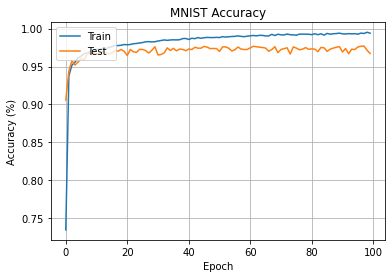

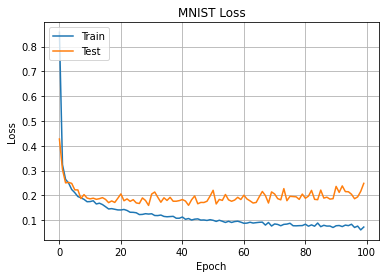

In [10]:
##
# Visualize the train/validation accuracy and loss after the training duration:
#
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("MNIST Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid(True)
plt.show()
###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("MNIST Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid(True)
plt.show()

## II. Benchmark with Zalando MNIST dataset <a name = 'Test02'></a>

In [11]:
##
# Load the Zalando MNIST dataset:
#
X_train, y_train = process_mnist.load_mnist('data/fashion', kind = 'train')
X_test, y_test = process_mnist.load_mnist('data/fashion', kind = 't10k')


##
# Convert the input data into RGB image type and resize the resolution to 32x32:
#
X_train = process_mnist.resize_mnist(X_train, 32, 28)
X_train = np.stack((X_train,) * 3, axis = -1)
X_test = process_mnist.resize_mnist(X_test, 32, 28)
X_test = np.stack((X_test,) * 3, axis = -1)

##
# One-hot encoding the output labels:
#
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [12]:
##
# Sanity check for input and output dimensions:
#
assert X_train.shape == (60000,32,32,3), "X_train should have a dimension of (60000,32,32,3)!"
assert X_test.shape == (10000,32,32,3), "X_test should have a dimension of (10000,32,32,3)!"
assert y_train.shape == (60000,10), "y_train should have a dimension of (60000,10)"
assert y_test.shape == (10000,10), "y_test should have a dimension of (10000,10)"

In [14]:
##
# Extract the best model based on validation accuracy:
#
#filepath = "classifiers/%s-{epoch:02d}-{val_accuracy:.4f}-fashion.hdf5"%full_name
#checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', save_best_only = True, mode = 'max')
#callbacks_list = [checkpoint]

###
# Train the model and store the execution time for evaluation:
#
start = time.time()
history = model.fit(X_train, y_train, epochs = 100, verbose = 1, batch_size = 64, callbacks = callbacks_list,
                         shuffle = True, validation_data = (X_test, y_test))
end = time.time()
runtime_fashion = end - start

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 23s 383us/sample - loss: 1.0631 - accuracy: 0.6992 - Precision: 0.8221 - Recall: 0.6016 - val_loss: 0.7433 - val_accuracy: 0.7851 - val_Precision: 0.8508 - val_Recall: 0.7232
Epoch 2/100
60000/60000 [==============================] - 23s 384us/sample - loss: 0.6894 - accuracy: 0.8054 - Precision: 0.8565 - Recall: 0.7558 - val_loss: 0.6542 - val_accuracy: 0.8123 - val_Precision: 0.8549 - val_Recall: 0.7780
Epoch 3/100
60000/60000 [==============================] - 23s 385us/sample - loss: 0.6204 - accuracy: 0.8230 - Precision: 0.8664 - Recall: 0.7812 - val_loss: 0.6340 - val_accuracy: 0.8149 - val_Precision: 0.8508 - val_Recall: 0.7852
Epoch 4/100
60000/60000 [==============================] - 23s 387us/sample - loss: 0.5787 - accuracy: 0.8342 - Precision: 0.8739 - Recall: 0.7947 - val_loss: 0.5867 - val_accuracy: 0.8321 - val_Precision: 0.8771 - val_Recall: 0.7972
Epoch 5/100
60

Epoch 36/100
60000/60000 [==============================] - 24s 392us/sample - loss: 0.3484 - accuracy: 0.9063 - Precision: 0.9237 - Recall: 0.8898 - val_loss: 0.5480 - val_accuracy: 0.8610 - val_Precision: 0.8804 - val_Recall: 0.8438
Epoch 37/100
60000/60000 [==============================] - 24s 392us/sample - loss: 0.3491 - accuracy: 0.9056 - Precision: 0.9242 - Recall: 0.8900 - val_loss: 0.5319 - val_accuracy: 0.8646 - val_Precision: 0.8819 - val_Recall: 0.8504
Epoch 38/100
60000/60000 [==============================] - 24s 392us/sample - loss: 0.3502 - accuracy: 0.9073 - Precision: 0.9248 - Recall: 0.8917 - val_loss: 0.5507 - val_accuracy: 0.8585 - val_Precision: 0.8775 - val_Recall: 0.8466
Epoch 39/100
60000/60000 [==============================] - 23s 391us/sample - loss: 0.3452 - accuracy: 0.9090 - Precision: 0.9259 - Recall: 0.8928 - val_loss: 0.5477 - val_accuracy: 0.8592 - val_Precision: 0.8797 - val_Recall: 0.8434
Epoch 40/100
60000/60000 [==============================] - 

Epoch 71/100
60000/60000 [==============================] - 23s 390us/sample - loss: 0.2951 - accuracy: 0.9289 - Precision: 0.9408 - Recall: 0.9183 - val_loss: 0.6036 - val_accuracy: 0.8593 - val_Precision: 0.8786 - val_Recall: 0.8468
Epoch 72/100
60000/60000 [==============================] - 24s 392us/sample - loss: 0.2808 - accuracy: 0.9317 - Precision: 0.9425 - Recall: 0.9214 - val_loss: 0.6547 - val_accuracy: 0.8605 - val_Precision: 0.8748 - val_Recall: 0.8517
Epoch 73/100
60000/60000 [==============================] - 24s 392us/sample - loss: 0.2882 - accuracy: 0.9300 - Precision: 0.9413 - Recall: 0.9207 - val_loss: 0.6388 - val_accuracy: 0.8608 - val_Precision: 0.8760 - val_Recall: 0.8501
Epoch 74/100
60000/60000 [==============================] - 24s 392us/sample - loss: 0.2868 - accuracy: 0.9311 - Precision: 0.9426 - Recall: 0.9216 - val_loss: 0.6458 - val_accuracy: 0.8626 - val_Precision: 0.8723 - val_Recall: 0.8545
Epoch 75/100
60000/60000 [==============================] - 

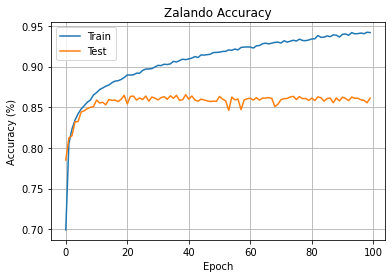

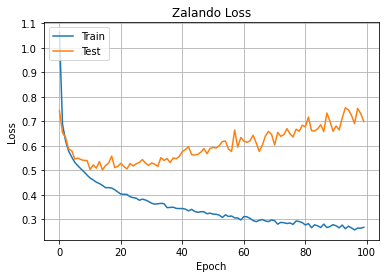

In [15]:
##
# Visualize the train/validation accuracy and loss after the training duration:
#
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Zalando Accuracy")
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid(True)
plt.show() 
###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Zalando Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid(True)
plt.show()

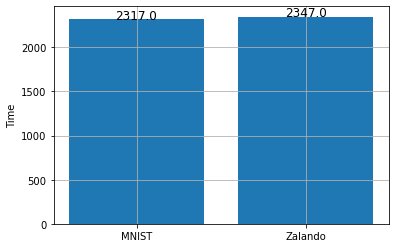

In [16]:
##
# Visualize the execution time on each dataset, respectively: 
#
values = [round(runtime_mnist,0) , round(runtime_fashion,0)]
names = ['MNIST', 'Zalando']

plt.bar(names, values)
plt.ylabel('Time')
plt.grid(True)

for index, data in enumerate(values):
    plt.text(x = index , y = data + 1 , s = f"{data}" , fontdict = dict(fontsize = 12), ha = 'center')
    
plt.show()